In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
df = pd.read_excel('Merge_Final.xlsx')
df.head()

,Fecha,Ingresos,Costos
0,2016-10-10,4.300510,8.037570
1,2016-10-15,5.900000,3.225530
2,2016-10-17,1.764100,2.360000
3,2016-10-18,6.167624,2.292655
4,2016-10-28,1.292100,2.360000


In [ ]:
print(df.columns)

Index(['Fecha', 'Ingresos', 'Costos'], dtype='object')


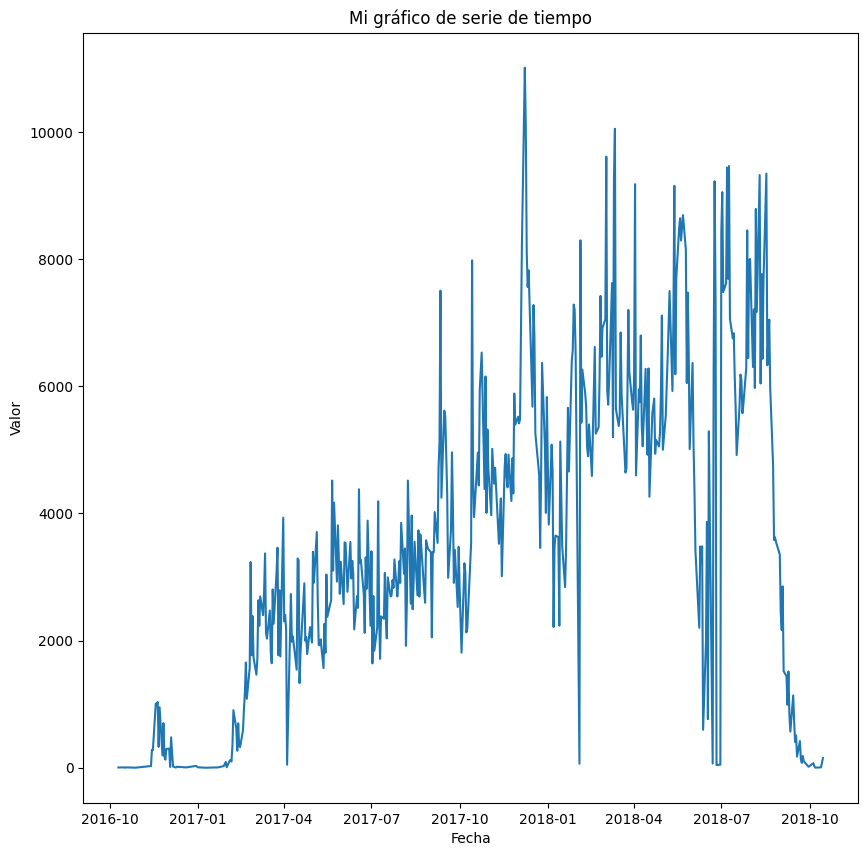

In [ ]:
plt.figure(figsize=(10,10))
plt.plot(df['Fecha'], df['Ingresos'])
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.title('Mi gráfico de serie de tiempo')
plt.show()

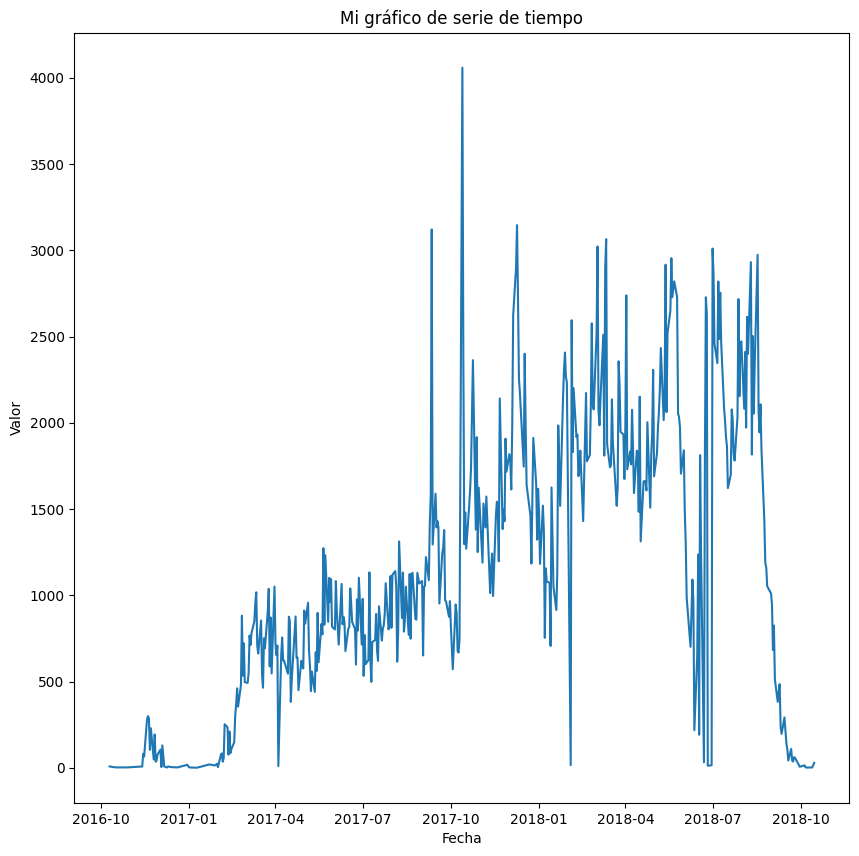

In [ ]:
plt.figure(figsize=(10, 10))
plt.plot(df['Fecha'], df['Costos'])
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.title('Mi gráfico de serie de tiempo')
plt.show()

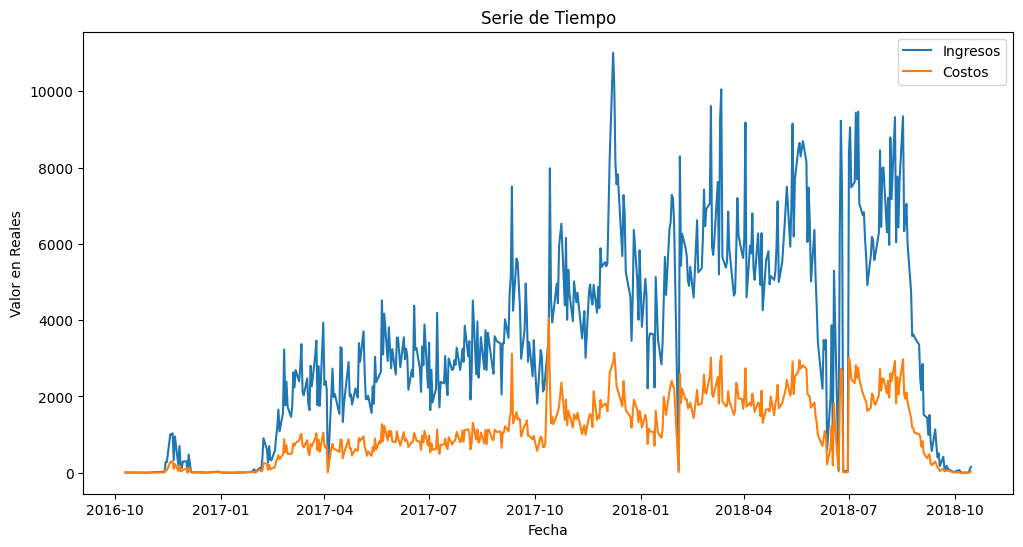

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(df['Fecha'], df['Ingresos'], label='Ingresos')
plt.plot(df['Fecha'], df['Costos'], label='Costos')
plt.xlabel('Fecha')
plt.ylabel('Valor en Reales')
plt.title('Serie de Tiempo')
plt.legend()
plt.show()

In [ ]:
fecha_limite_str = '2018-10-15'
fecha_limite = pd.to_datetime(fecha_limite_str)
fecha_limite = fecha_limite - pd.DateOffset(months=2)
serie_nueva = df.loc[df['Fecha'] <= fecha_limite, 'Ingresos']

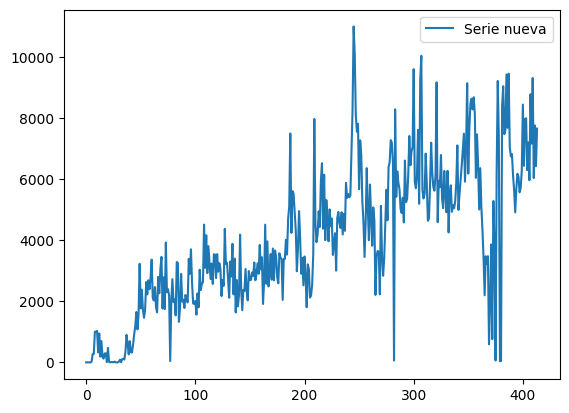

In [ ]:
plt.plot(serie_nueva.index, serie_nueva.values, label='Serie nueva')
plt.legend(loc='best')
plt.show()

In [ ]:
df = df.loc[serie_nueva.index]
df

,Fecha,Ingresos,Costos
0,2016-10-10,4.300510,8.037570
1,2016-10-15,5.900000,3.225530
2,2016-10-17,1.764100,2.360000
3,2016-10-18,6.167624,2.292655
4,2016-10-28,1.292100,2.360000
...,...,...,...
409,2018-08-10,9324.231262,2931.499487
410,2018-08-11,6045.539548,1815.961332
411,2018-08-12,7766.618636,2502.581506
412,2018-08-13,6432.711944,2053.469102


Le sacamos los ultimos dos meses porque no podemos hacer una buena estimación.

In [ ]:
from statsmodels.tsa.stattools import adfuller

resultado = adfuller(df['Ingresos'])
if resultado[1] < 0.05:
    print('La serie de tiempo es estacionaria')
else:
    print('La serie de tiempo no es estacionaria')

La serie de tiempo no es estacionaria


Como la serie no es estacionario tendremos que derivarla. 

In [ ]:
datos_derivados = df.diff().dropna()
resultado = adfuller(df['Ingresos'])
if resultado[1] < 0.05:
    print('La serie derivada es estacionaria')
else:
    print('La serie derivada no es estacionaria')

La serie derivada no es estacionaria


In [ ]:
datos_derivados['Fecha'] = df['Fecha'].iloc[1:]

In [ ]:
datos_derivados1 = datos_derivados.diff().dropna()
resultado = adfuller(datos_derivados['Ingresos'])
if resultado[1] < 0.05:
    print('La serie derivada es estacionaria')
else:
    print('La serie derivada no es estacionaria')

La serie derivada es estacionaria


In [ ]:
datos_derivados1['Fecha'] = df['Fecha'].iloc[1:]

Usaremos un ARIMA de orden 2. Esto se debe a que derivamos dos veces. Lo que varían las variaciones. 

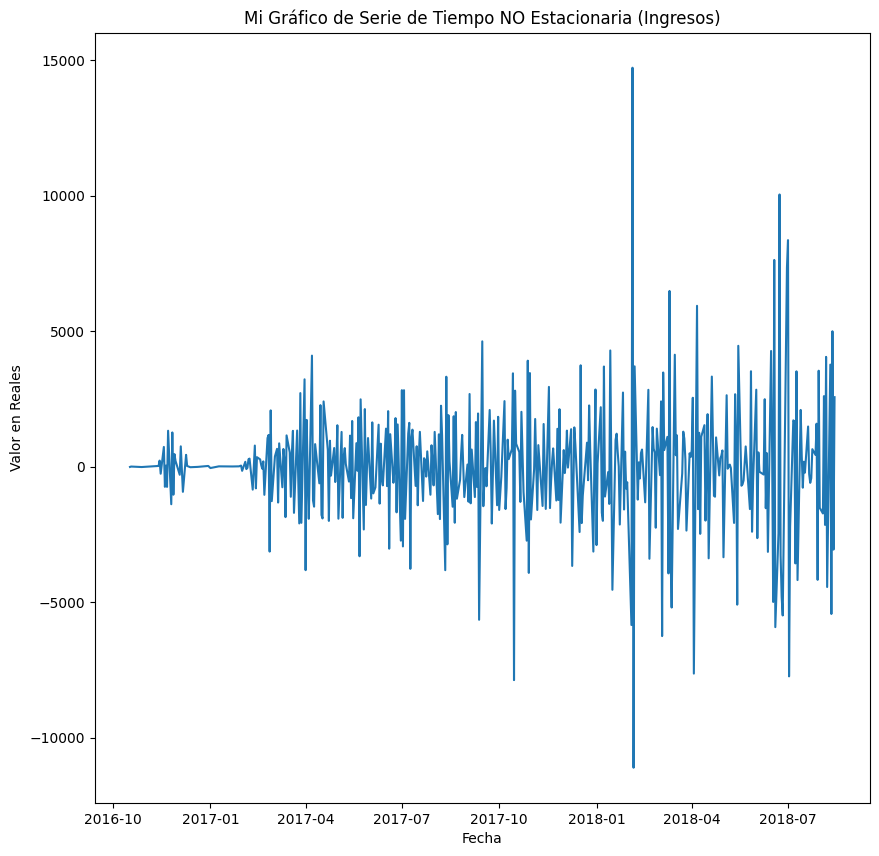

In [ ]:
plt.figure(figsize=(10,10))
plt.plot(datos_derivados1['Fecha'], datos_derivados1['Ingresos'])
plt.xlabel('Fecha')
plt.ylabel('Valor en Reales')
plt.title('Mi Gráfico de Serie de Tiempo NO Estacionaria (Ingresos)')
plt.show()

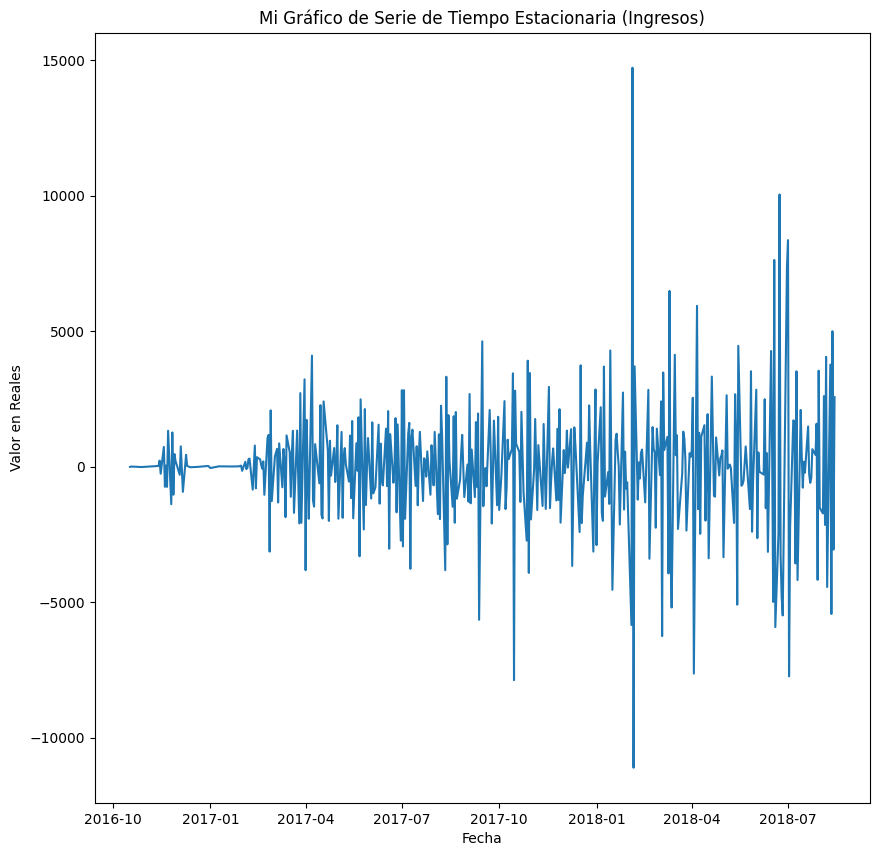

In [ ]:
plt.figure(figsize=(10,10))
plt.plot(datos_derivados1['Fecha'], datos_derivados1['Ingresos'])
plt.xlabel('Fecha')
plt.ylabel('Valor en Reales')
plt.title('Mi Gráfico de Serie de Tiempo Estacionaria (Ingresos)')
plt.show()

/usr/local/lib/python3.10/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


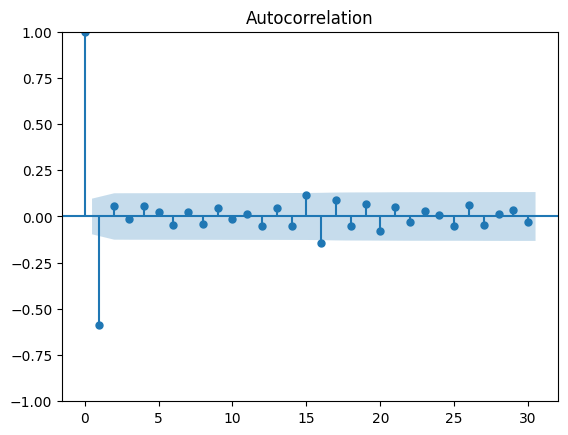

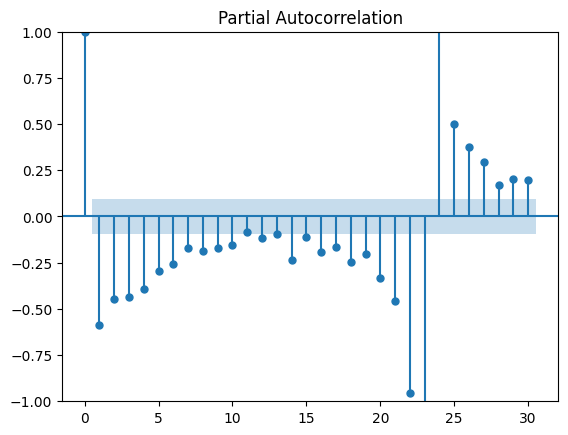

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(datos_derivados1['Ingresos'], lags=30)
plot_pacf(datos_derivados1['Ingresos'], lags=30)
plt.show()

Graficamos la función de Autocorrelacion y funcion de Autocorrelacion Parcial. En la gráfica de autocorrelacion parcial la caída es de forma exponencial por lo que podemos representar el modelo con un AR. 
A su vez, vemos que lo que pasó hace 23 días es muy influyente en lo que va a pasar hoy. Por lo tanto, tenemos un patrón de estacionalidad cada 23 días. Tambien se puede representar con un MA porque la funcion de autocorrelacion tambien cae exponencialmente.
En la parte MA utilizaremos un 1 y en la parte AR un 1.
Utilizaremos un modelo SARIMA.

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
modelo = SARIMAX(df['Ingresos'], order=(1, 2, 1), seasonal_order=(1, 0, 0, 23))
modelo_ajustado = modelo.fit()

In [ ]:
datos_ajustados = modelo_ajustado.predict(start=0, end=len(df)-1)
datos_ajustados = modelo_ajustado.predict(start=0, end=len(df)-1)

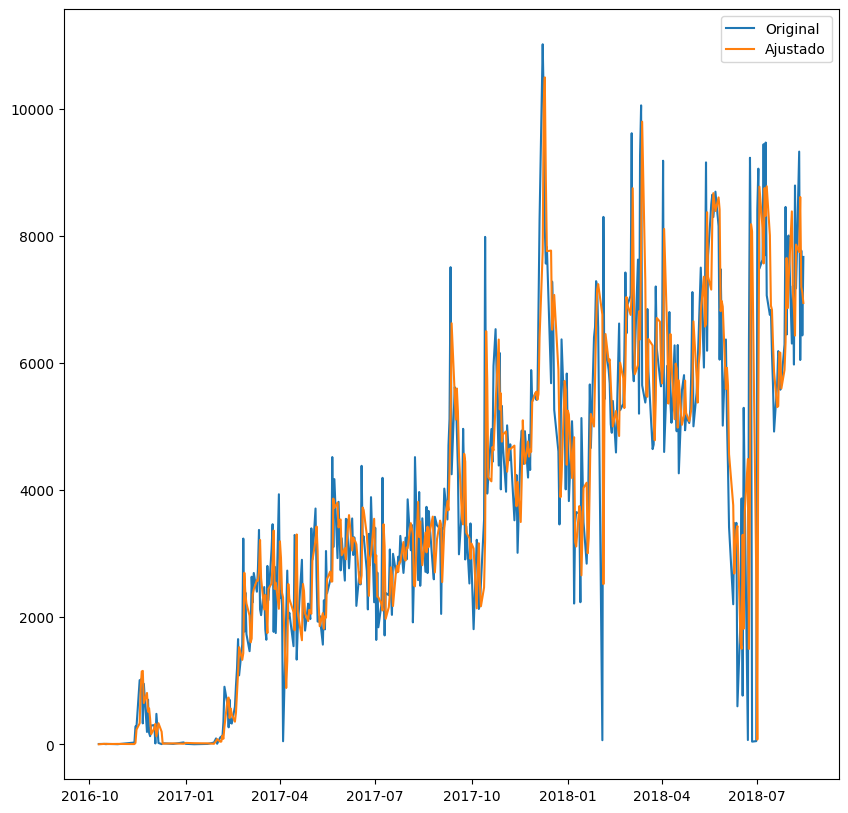

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))
plt.plot(df['Fecha'], df['Ingresos'], label='Original')
plt.plot(df['Fecha'], datos_ajustados, label='Ajustado')
plt.legend(loc='best')
plt.show()

In [ ]:
prediccion = modelo_ajustado.predict(start=len(df), end=len(df)+16)

In [ ]:
nuevos_datos_ingresos = pd.DataFrame({'Fecha': pd.date_range(start=df['Fecha'].iloc[-1], periods=17, freq='M'), 'Ingresos': prediccion})
datos_completos = pd.concat([df, nuevos_datos], ignore_index=True)

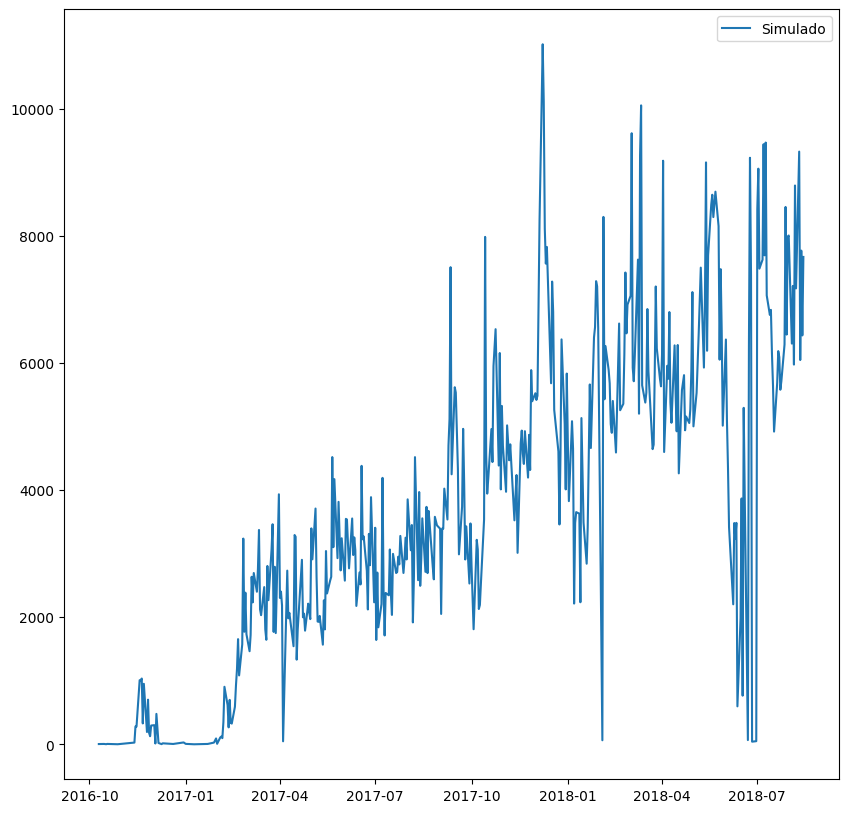

In [ ]:
plt.figure(figsize=(10,10))
plt.plot(datos_completos['Fecha'], datos_completos['Ingresos'], label='Simulado')
plt.legend(loc='best')
plt.show()

In [ ]:
df


,Fecha,Ingresos,Costos
0,2016-10-10,4.300510,8.037570
1,2016-10-15,5.900000,3.225530
2,2016-10-17,1.764100,2.360000
3,2016-10-18,6.167624,2.292655
4,2016-10-28,1.292100,2.360000
...,...,...,...
409,2018-08-10,9324.231262,2931.499487
410,2018-08-11,6045.539548,1815.961332
411,2018-08-12,7766.618636,2502.581506
412,2018-08-13,6432.711944,2053.469102


In [ ]:
nuevos_datos_ingresos

,Fecha,Ingresos
414,2018-08-31,7207.993864
415,2018-09-30,7367.282856
416,2018-10-31,7292.978011
417,2018-11-30,7365.063573
418,2018-12-31,7395.336403
419,2019-01-31,7411.222340
420,2019-02-28,7404.974238
421,2019-03-31,7428.192590
422,2019-04-30,7469.708620
423,2019-05-31,7579.809827


Predicción de los Ingresos con dato.

In [ ]:
# Exportar el DataFrame a un archivo de Excel
nuevos_datos.to_excel('datos1.xlsx', index=False)

In [ ]:
from statsmodels.tsa.stattools import adfuller

resultado = adfuller(df['Costos'])
if resultado[1] < 0.05:
    print('La serie de tiempo es estacionaria')
else:
    print('La serie de tiempo no es estacionaria')

La serie de tiempo no es estacionaria


Como la serie no es estacionario tendremos que derivarla. 

In [ ]:
datos_derivados2 = df.diff().dropna()
resultado = adfuller(df['Costos'])
if resultado[1] < 0.05:
    print('La serie derivada es estacionaria')
else:
    print('La serie derivada no es estacionaria')

La serie derivada no es estacionaria


In [ ]:
datos_derivados2['Fecha'] = df['Fecha'].iloc[1:]

In [ ]:
datos_derivados2 = datos_derivados.diff().dropna()
resultado = adfuller(datos_derivados['Costos'])
if resultado[1] < 0.05:
    print('La serie derivada es estacionaria')
else:
    print('La serie derivada no es estacionaria')

La serie derivada es estacionaria


In [ ]:
datos_derivados2['Fecha'] = df['Fecha'].iloc[1:]

Usaremos un ARIMA de orden 2. Esto se debe a que derivamos dos veces. Lo que varían las variaciones. 

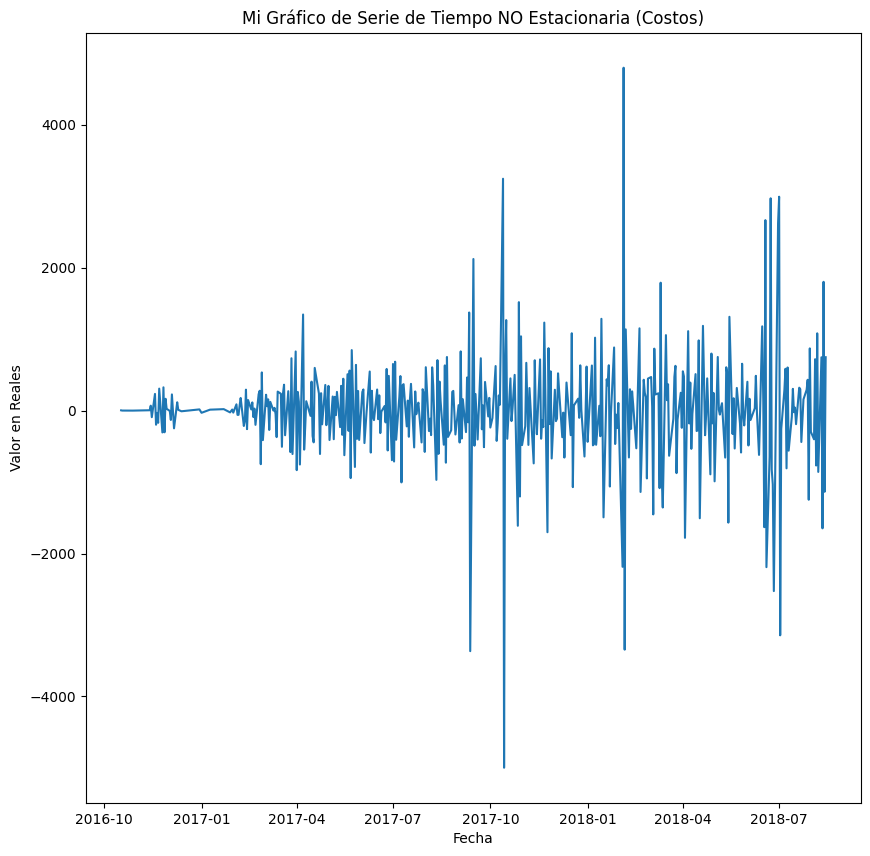

In [ ]:
plt.figure(figsize=(10,10))
plt.plot(datos_derivados2['Fecha'], datos_derivados2['Costos'])
plt.xlabel('Fecha')
plt.ylabel('Valor en Reales')
plt.title('Mi Gráfico de Serie de Tiempo NO Estacionaria (Costos)')
plt.show()

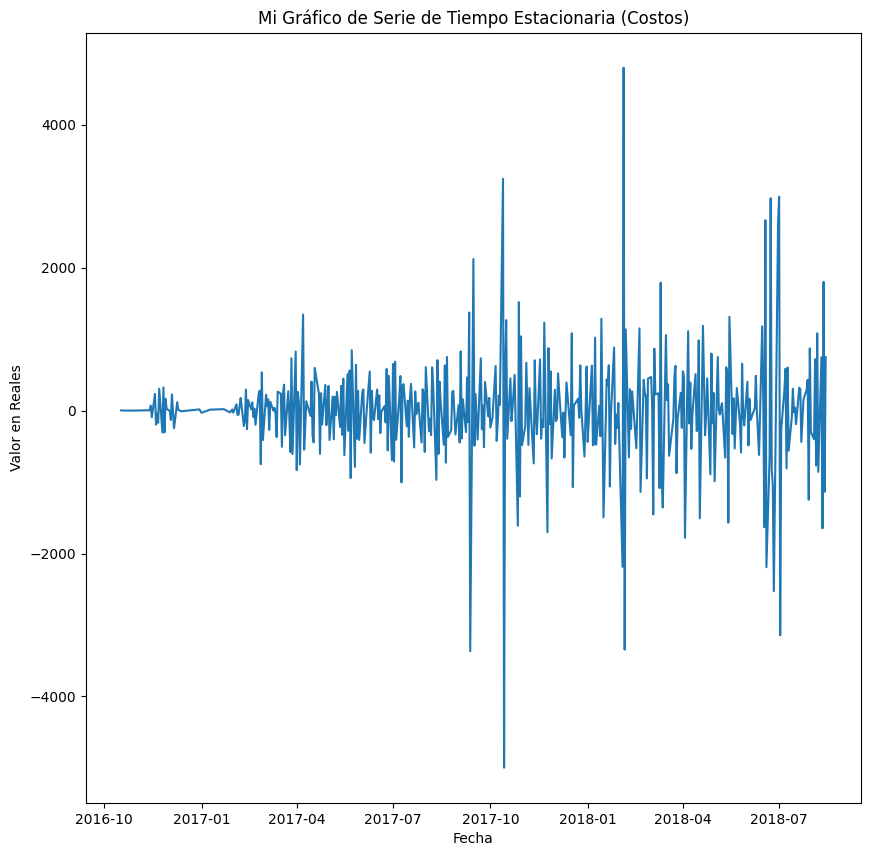

In [ ]:
plt.figure(figsize=(10,10))
plt.plot(datos_derivados2['Fecha'], datos_derivados2['Costos'])
plt.xlabel('Fecha')
plt.ylabel('Valor en Reales')
plt.title('Mi Gráfico de Serie de Tiempo Estacionaria (Costos)')
plt.show()

/usr/local/lib/python3.10/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


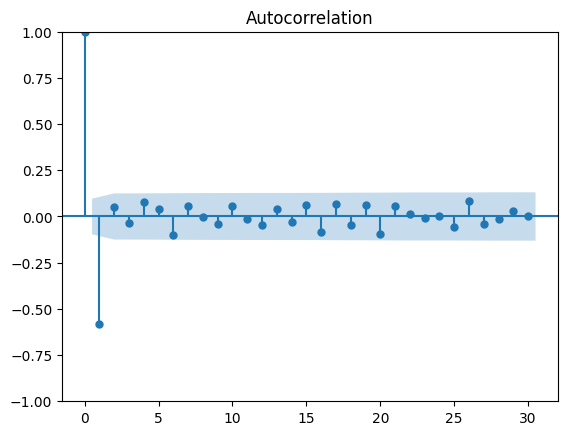

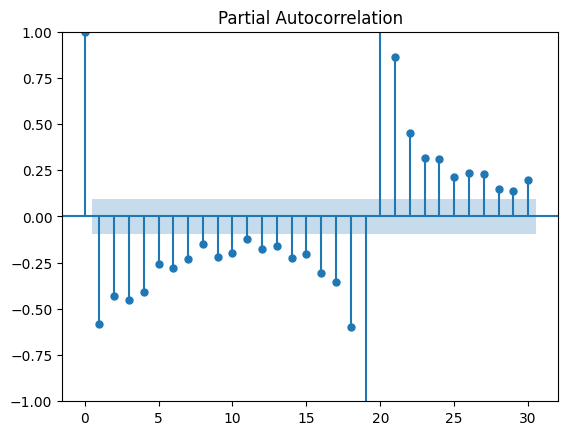

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(datos_derivados2['Costos'], lags=30)
plot_pacf(datos_derivados2['Costos'], lags=30)
plt.show()

Graficamos la función de Autocorrelacion y funcion de Autocorrelacion Parcial. En la gráfica de autocorrelacion parcial la caída es de forma exponencial por lo que podemos representar el modelo con un AR. 
A su vez, vemos que lo que pasó hace 20 días es muy influyente en lo que va a pasar hoy. Por lo tanto, tenemos un patrón de estacionalidad cada 20 días. Tambien se puede representar con un MA porque la funcion de autocorrelacion tambien cae exponencialmente.
En la parte MA utilizaremos un 1 y en la parte AR un 1.
Utilizaremos un modelo SARIMA.

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
modelo = SARIMAX(df['Costos'], order=(1, 2, 1), seasonal_order=(1, 0, 0, 20))
modelo_ajustado = modelo.fit()

In [ ]:
datos_ajustados = modelo_ajustado.predict(start=0, end=len(df)-1)
datos_ajustados = modelo_ajustado.predict(start=0, end=len(df)-1)

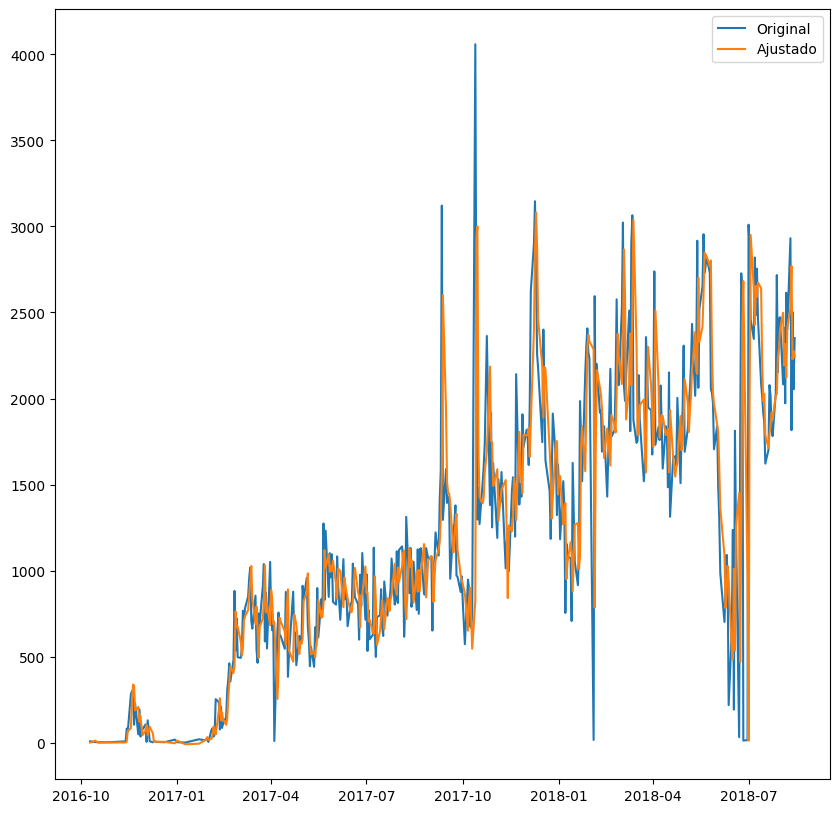

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))
plt.plot(df['Fecha'], df['Costos'], label='Original')
plt.plot(df['Fecha'], datos_ajustados, label='Ajustado')
plt.legend(loc='best')
plt.show()

In [ ]:
prediccion = modelo_ajustado.predict(start=len(df), end=len(df)+16)

In [ ]:
nuevos_datos_costos = pd.DataFrame({'Fecha': pd.date_range(start=df['Fecha'].iloc[-1], periods=17, freq='M'), 'Costos': prediccion})
datos_completos = pd.concat([df, nuevos_datos], ignore_index=True)

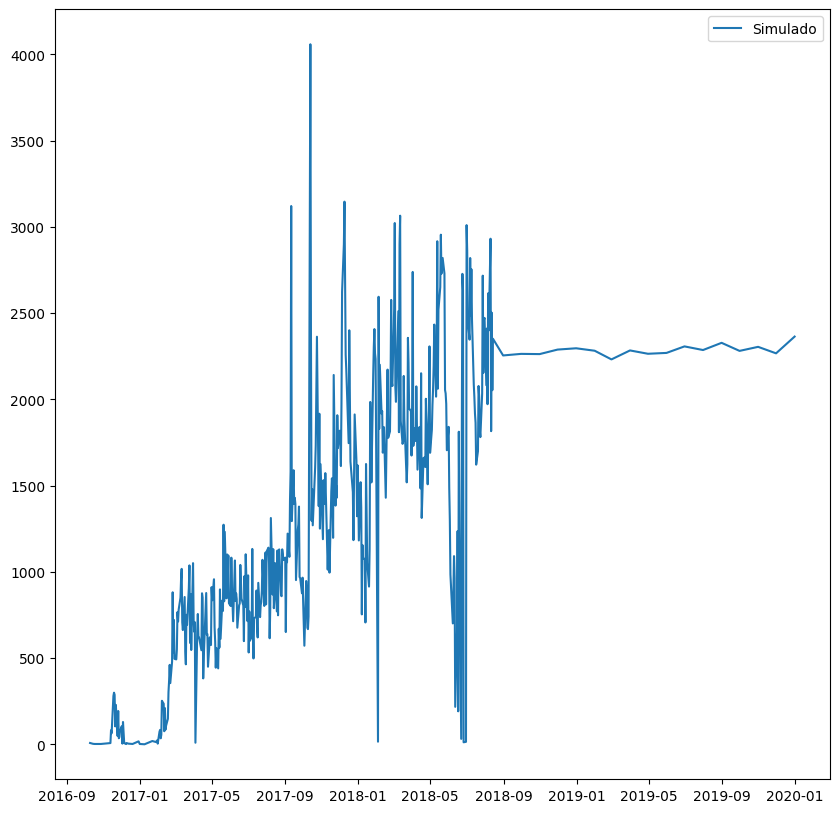

In [ ]:
plt.figure(figsize=(10,10))
plt.plot(datos_completos['Fecha'], datos_completos['Costos'], label='Simulado')
plt.legend(loc='best')
plt.show()

In [ ]:
nuevos_datos_costos

,Fecha,Costos
414,2018-08-31,2254.759260
415,2018-09-30,2263.856974
416,2018-10-31,2262.610733
417,2018-11-30,2288.795187
418,2018-12-31,2296.334825
419,2019-01-31,2282.087844
420,2019-02-28,2231.816900
421,2019-03-31,2283.827491
422,2019-04-30,2264.510689
423,2019-05-31,2269.465471


Predicción de los Costos con dato.

In [ ]:
# Exportar el DataFrame a un archivo de Excel
nuevos_datos.to_excel('datos.xlsx', index=False)

In [ ]:
# Crear los dataframes de los costos e ingresos
costos = pd.DataFrame({'Fecha': ['2018-08-31', '2018-09-30', '2018-10-31', '2018-11-30', '2018-12-31', '2019-01-31', '2019-02-28', '2019-03-31', '2019-04-30', '2019-05-31', '2019-06-30', '2019-07-31', '2019-08-31', '2019-09-30', '2019-10-31', '2019-11-30', '2019-12-31'], 'Costos': [2254.759260, 2263.856974, 2262.610733, 2288.795187, 2296.334825, 2282.087844, 2231.816900, 2283.827491, 2264.510689, 2269.465471, 2307.249341, 2286.185176, 2327.948128, 2281.220613, 2304.656881, 2267.018779, 2364.140585]})

ingresos = pd.DataFrame({'Fecha': ['2018-08-31', '2018-09-30', '2018-10-31', '2018-11-30', '2018-12-31', '2019-01-31', '2019-02-28', '2019-03-31', '2019-04-30', '2019-05-31', '2019-06-30', '2019-07-31', '2019-08-31', '2019-09-30', '2019-10-31', '2019-11-30', '2019-12-31'], 'Ingresos': [7207.993864, 7367.282856, 7292.978011, 7365.063573, 7395.336403, 7411.222340, 7404.974238, 7428.192590, 7469.708620, 7579.809827, 7510.343144, 7593.402832, 7611.297847, 7555.082940, 7611.029569, 7574.741169, 7712.886296]})

costos['Fecha'] = pd.to_datetime(costos['Fecha'])
ingresos['Fecha'] = pd.to_datetime(ingresos['Fecha'])

datos = pd.merge(costos, ingresos, on='Fecha')
print(datos)

        Fecha       Costos     Ingresos
0  2018-08-31  2254.759260  7207.993864
1  2018-09-30  2263.856974  7367.282856
2  2018-10-31  2262.610733  7292.978011
3  2018-11-30  2288.795187  7365.063573
4  2018-12-31  2296.334825  7395.336403
5  2019-01-31  2282.087844  7411.222340
6  2019-02-28  2231.816900  7404.974238
7  2019-03-31  2283.827491  7428.192590
8  2019-04-30  2264.510689  7469.708620
9  2019-05-31  2269.465471  7579.809827
10 2019-06-30  2307.249341  7510.343144
11 2019-07-31  2286.185176  7593.402832
12 2019-08-31  2327.948128  7611.297847
13 2019-09-30  2281.220613  7555.082940
14 2019-10-31  2304.656881  7611.029569
15 2019-11-30  2267.018779  7574.741169
16 2019-12-31  2364.140585  7712.886296


In [ ]:
datos

,Fecha,Costos,Ingresos
0,2018-08-31,2254.759260,7207.993864
1,2018-09-30,2263.856974,7367.282856
2,2018-10-31,2262.610733,7292.978011
3,2018-11-30,2288.795187,7365.063573
4,2018-12-31,2296.334825,7395.336403
5,2019-01-31,2282.087844,7411.222340
6,2019-02-28,2231.816900,7404.974238
7,2019-03-31,2283.827491,7428.192590
8,2019-04-30,2264.510689,7469.708620
9,2019-05-31,2269.465471,7579.809827


In [ ]:
datos["Rentabilidad"] =  datos["Ingresos"]-datos["Costos"]
datos

,Fecha,Costos,Ingresos,Rentabilidad
0,2018-08-31,2254.759260,7207.993864,4953.234604
1,2018-09-30,2263.856974,7367.282856,5103.425882
2,2018-10-31,2262.610733,7292.978011,5030.367278
3,2018-11-30,2288.795187,7365.063573,5076.268386
4,2018-12-31,2296.334825,7395.336403,5099.001578
5,2019-01-31,2282.087844,7411.222340,5129.134496
6,2019-02-28,2231.816900,7404.974238,5173.157338
7,2019-03-31,2283.827491,7428.192590,5144.365099
8,2019-04-30,2264.510689,7469.708620,5205.197931
9,2019-05-31,2269.465471,7579.809827,5310.344356


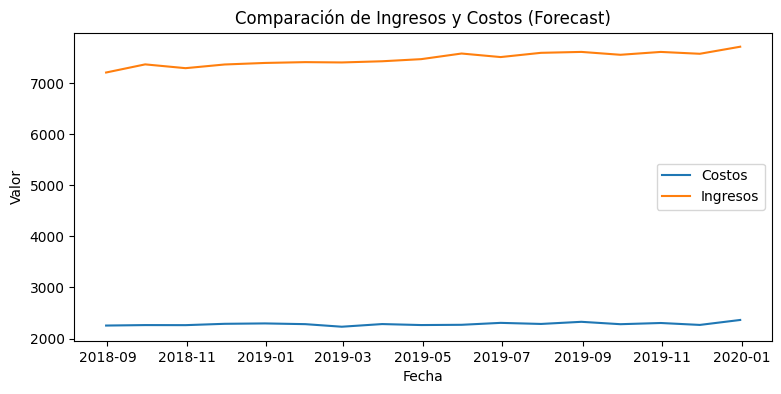

In [ ]:
# Seleccionar los datos de interés
fechas = datos['Fecha']
costos = datos['Costos']
ingresos = datos['Ingresos']

# Configurar la figura
plt.figure(figsize=(9, 4))
plt.title('Comparación de Ingresos y Costos (Forecast)')
plt.xlabel('Fecha')
plt.ylabel('Valor')

# Graficar los datos
plt.plot(fechas, costos, label='Costos')
plt.plot(fechas, ingresos, label='Ingresos')

# Agregar leyenda y mostrar la figura
plt.legend()
plt.show()

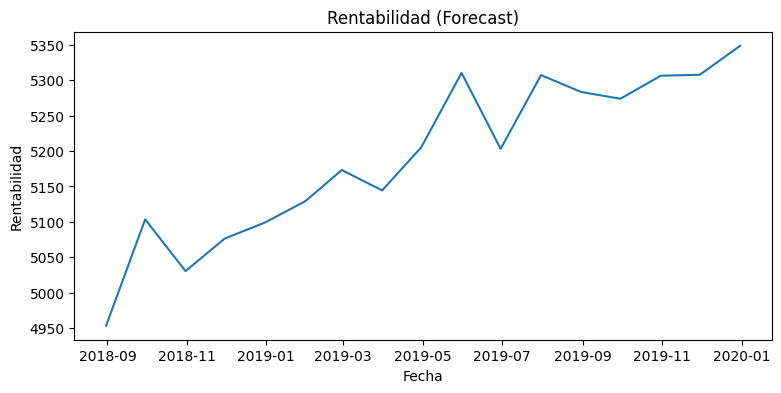

In [ ]:
plt.figure(figsize=(9, 4))
plt.plot(datos['Fecha'], datos['Rentabilidad'])

# Añadir títulos y etiquetas a los ejes

plt.title('Rentabilidad (Forecast)')
plt.xlabel('Fecha')
plt.ylabel('Rentabilidad')

# Mostrar la gráfica
plt.show()